# Chat Intents

## Topic Modeling

**Summary**

This notebook explores the possibilty of using topic modeling to extract intents from the 1,000 sample subset of the overall bank77 dataset. The scikit-learn and gensim implementations of LDA are investigated. Additionally, Correlation Explanation (https://github.com/gregversteeg/corex_topic), or CorEx, is also included in the analysis. As shown in the analysis below, one of the biggest challenges is identifying how many topics to include.

In order to avoid some package dependency conflicts, this notebook was created in a separate virtual environment than the rest of the notebooks and code in this repo. Before being able to run the below notebook, install gensim, pyLDAvis, and CorEx using:

`pip install gensim`

`pip install pyldavis`

`pip install corextopic`

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn import metrics
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.manifold import TSNE

import gensim
from gensim.corpora.dictionary import Dictionary
from gensim.models.phrases import Phrases, Phraser
from gensim.models import CoherenceModel
import pyLDAvis
import pyLDAvis.gensim_models
from corextopic import corextopic as ct

import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

pd.set_option("display.max_rows", 500)
pd.set_option("display.max_columns", 500)
pd.set_option("max_colwidth", 400)

In [3]:
data_sample = pd.read_csv('../data/processed/data_sample.csv')
data_sample.head()

,Unnamed: 0,text,category,cleaned_text
0,1024,I'm worried my card might be lost in the mail? How long does it usually take to arrive?,card_delivery_estimate,im worried card might lost mail long usually take arrive
1,9405,I got charged a fee that shouldn't be there from my cash,cash_withdrawal_charge,got charged fee shouldnt cash
2,9368,Do you charge for making a withdrawal? I took some money out of my account earlier and I was charged for this.,cash_withdrawal_charge,charge making withdrawal took money account earlier charged
3,3414,Is there an issue with my account? I don't see a cheque deposit that I made yesterday. Please assist.,balance_not_updated_after_cheque_or_cash_deposit,issue account dont see cheque deposit made yesterday please assist
4,7402,Are there ways for other people to send me money?,receiving_money,way people send money


In [4]:
X = data_sample['cleaned_text']
X.head()

0              im worried card might lost mail long usually take arrive
1                                         got charged fee shouldnt cash
2           charge making withdrawal took money account earlier charged
3    issue account dont see cheque deposit made yesterday please assist
4                                                 way people send money
Name: cleaned_text, dtype: object

In [5]:
len(X)

1000

## LDA with Scikit-learn

In [6]:
count_vectorizer = CountVectorizer(ngram_range = (1, 2), max_df = 900, min_df = 10)

transformed_vector = count_vectorizer.fit_transform(X)
transformed_vector.shape

(1000, 144)

In [7]:
feature_names = count_vectorizer.get_feature_names()
feature_names[0:10]

['able',
 'accept',
 'account',
 'ago',
 'already',
 'amount',
 'app',
 'atm',
 'back',
 'balance']

In [8]:
%%time

perplexities = []
for NUM_TOPICS in range(5,101):
    lda_model = LatentDirichletAllocation(n_components = NUM_TOPICS, max_iter=20)
    lda = lda_model.fit_transform(transformed_vector)
    perplexities.append(lda_model.perplexity(transformed_vector))

CPU times: user 2min 52s, sys: 1.62 s, total: 2min 54s
Wall time: 3min 27s


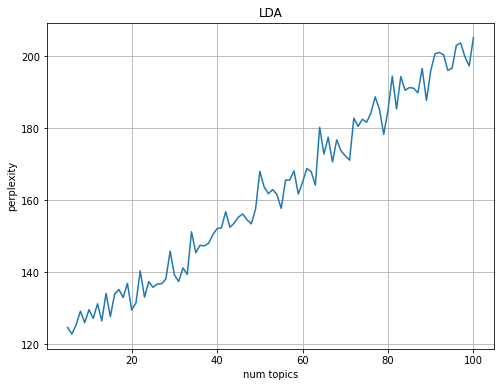

In [14]:
x = range(5, 101)
y = perplexities

fig, ax = plt.subplots(figsize=(8,6))
ax.plot(x, y)

ax.set(xlabel = 'num topics', ylabel = 'perplexity', title = 'LDA')
ax.grid()

plt.show()

In [11]:
%%time

scores = []
for NUM_TOPICS in range(5,101):
    lda_model = LatentDirichletAllocation(n_components = NUM_TOPICS, max_iter=20)
    lda = lda_model.fit_transform(transformed_vector)
    scores.append(lda_model.score(transformed_vector))

CPU times: user 2min 41s, sys: 1.15 s, total: 2min 42s
Wall time: 2min 49s


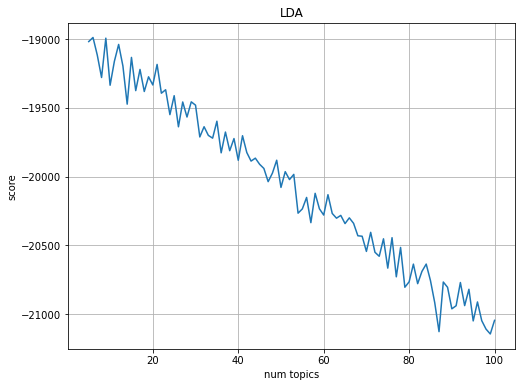

In [15]:
x = range(5, 101)
y = scores

fig, ax = plt.subplots(figsize=(8,6))
ax.plot(x, y)

ax.set(xlabel = 'num topics', ylabel = 'score', title = 'LDA')
ax.grid()

plt.show()

Some literature suggests that it might be possible to use perplexity (https://en.wikipedia.org/wiki/Perplexity)  to determine an optimal number of topics, but others have questioned relying on it. Regardless, the scikit-learn implementation appears to still have a bug(https://github.com/scikit-learn/scikit-learn/issues/6777) that makes the perplexity value unreliable. 

### Evaluate a fixed number of topics

In [16]:
NUM_TOPICS = 15

lda_model = LatentDirichletAllocation(n_components = NUM_TOPICS, max_iter=20)

lda = lda_model.fit_transform(transformed_vector)
lda.shape

(1000, 15)

In [17]:
sum(lda[0])

1.0

In [18]:
lda_model.components_.shape

(15, 144)

In [19]:
lda_model.score(transformed_vector)

-19274.42495861938

In [20]:
def print_topic(identifier, top_words=10):
    for topic_id, topic_word_probs in enumerate(lda_model.components_):
        if topic_id == identifier:
            print(f"Topic {topic_id}: ")
            
            top_feature_names = [feature_names[i] for i in topic_word_probs.argsort()[: -top_words - 1: -1]]
            
            print(" ".join(top_feature_names))

In [21]:
for i in range(NUM_TOPICS):
    print_topic(i, top_words=10)

Topic 0: 
top use card currency pay tell phone bank cheque stolen
Topic 1: 
card exchange get rate exchange rate virtual virtual card disposable currency used
Topic 2: 
still pending find mastercard possible visa cash transfer earlier made
Topic 3: 
payment app card make card payment made cant didnt account receive
Topic 4: 
charge want debit direct direct debit card didnt see much statement
Topic 5: 
money working show tried balance isnt today check deposit account
Topic 6: 
cash card new withdrawal got cash withdrawal new card get charged reason
Topic 7: 
please help card account using please help cancel need someone made
Topic 8: 
topup long take time one go card transfer pending long take
Topic 9: 
fee charged money yet hasnt extra received transfer charged fee gone
Topic 10: 
would like would like purchase number card know wrong back much
Topic 11: 
account transfer money dont see declined whats going keep money account
Topic 12: 
work fund amount know card withdraw wrong wont atm

In [22]:
topics = []

for i in range(len(X)):
    topics.append(lda[i].argmax())

In [23]:
data_sample['topic'] = topics

data_sample.head()

,Unnamed: 0,text,category,cleaned_text,topic
0,1024,I'm worried my card might be lost in the mail? How long does it usually take to arrive?,card_delivery_estimate,im worried card might lost mail long usually take arrive,8
1,9405,I got charged a fee that shouldn't be there from my cash,cash_withdrawal_charge,got charged fee shouldnt cash,9
2,9368,Do you charge for making a withdrawal? I took some money out of my account earlier and I was charged for this.,cash_withdrawal_charge,charge making withdrawal took money account earlier charged,11
3,3414,Is there an issue with my account? I don't see a cheque deposit that I made yesterday. Please assist.,balance_not_updated_after_cheque_or_cash_deposit,issue account dont see cheque deposit made yesterday please assist,11
4,7402,Are there ways for other people to send me money?,receiving_money,way people send money,5


In [24]:
tsne = TSNE(n_components = 2, init = 'pca', random_state = 0)
lda_2d_tsne = tsne.fit_transform(lda)
lda_df_tsne = pd.DataFrame(lda_2d_tsne)
lda_df_tsne.shape

(1000, 2)

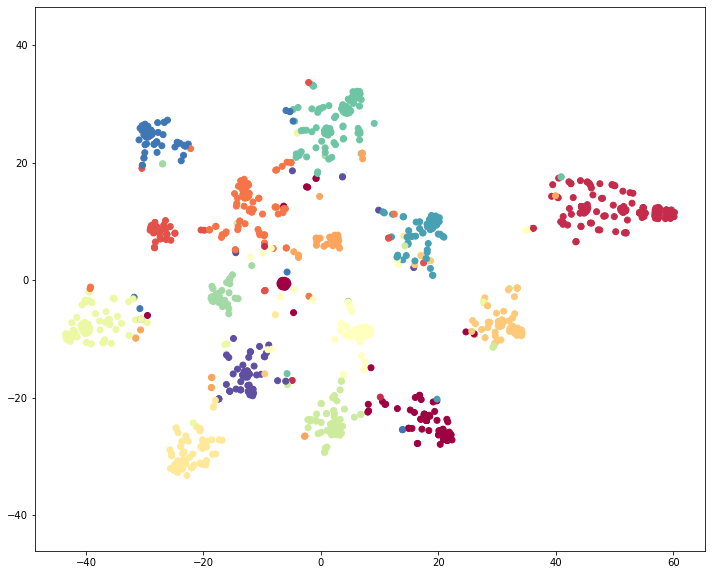

In [25]:
plt.subplots(figsize=(12, 10))
plt.axis('equal')

plt.scatter(lda_df_tsne[0], lda_df_tsne[1], c=data_sample['topic'], cmap = plt.cm.Spectral)

## LDA with Gensim

Gensim is a popular library for performing topic modeling and provides some additional functionality compared to the scikit-learn implementation.

In [26]:
all_messages = data_sample['cleaned_text'].values.tolist()
all_tokens = [sent.split(' ') for sent in all_messages]

In [27]:
# Add bigrams and trigrams to docs (only ones that appear 10 times or more).
bigram_phrases = Phrases(all_tokens, min_count=5)
bigram = Phraser(bigram_phrases)

for idx in range(len(all_tokens)):
    for token in bigram[all_tokens[idx]]:
        if '_' in token:
            # Token is a bigram, add to document.
            all_tokens[idx].append(token)

In [28]:
bigram.phrasegrams

{'charged_fee': 11.54074074074074,
 'exchange_rate': 61.20364550597109,
 'virtual_card': 10.742710795902285,
 'whats_going': 22.777777777777775,
 'visa_mastercard': 69.55357142857143,
 'verify_topup': 13.248299319727892,
 'extra_fee': 22.91176470588235,
 'please_help': 19.378109452736318,
 'direct_debit': 148.3809523809524,
 'disposable_virtual': 39.343434343434346,
 'would_like': 53.05689102564103,
 'change_pin': 22.17267552182163,
 'long_take': 24.481458202388435,
 'google_pay': 29.285714285714285,
 'cash_withdrawal': 21.061643835616437,
 'didnt_make': 14.78178368121442,
 'still_pending': 10.730027548209367}

In [29]:
dictionary = Dictionary(all_tokens)

# filter out words that occur less than 20 documents, or more than 50% of the documents.
dictionary.filter_extremes(no_below=10, no_above=0.9)

# bag-of-words representation of the documents
corpus = [dictionary.doc2bow(text) for text in all_tokens]

In [30]:
print('Number of unique tokens: %d' % len(dictionary))
print('Number of documents: %d' % len(corpus))

Number of unique tokens: 139
Number of documents: 1000


Similar size corpus as the scikit-learn implementation above

### Iterate through different topic sizes

There are numerous coherence metrics, as outlined in the paper (http://svn.aksw.org/papers/2015/WSDM_Topic_Evaluation/public.pdf ) that the gensim implementation is based.


In [33]:
def compute_coherence_values(corpus, dictionary, num_topics):
    """
    Returns coherence of LDA model based for a given number of topics
    
    Arguments:
        corpus: list, of bag-of-words representation of each document
        dictionary: gensim dictionary oboject of document tokens
        num_topics: int, number of topics to model
    Returns:
        coherence: Cv coherence measure of topic model
    """
    
    # Set training parameters
    chunksize = 2000
    passes = 20
    iterations = 400
    eval_every = None  
    
    # Make a index to word dictionary.
    temp = dictionary[0]  # This is only to "load" the dictionary.
    id2word = dictionary.id2token
    
    lda_model = gensim.models.LdaModel(corpus=corpus,
                                       id2word=id2word,
                                       chunksize=chunksize,
                                       alpha='auto',
                                       eta='auto',
                                       iterations=iterations,
                                       num_topics=num_topics,
                                       passes=passes,
                                       eval_every=eval_every
                                      )
    
    coherence_model_lda = CoherenceModel(model=lda_model, 
                                         texts=all_tokens, 
                                         dictionary=dictionary, 
                                         coherence='c_v')
    
    coherence = coherence_model_lda.get_coherence()
    #perplexity = lda_model.log_perplexity(corpus)  
    
    return coherence

In [34]:
%%time

coherence_scores = []
#perplexity_scores = []
for NUM_TOPICS in range(5,120):
    coherence = compute_coherence_values(corpus, dictionary, NUM_TOPICS)
    coherence_scores.append(coherence)
    #perplexity_scores.append(perplexity)

CPU times: user 7min 14s, sys: 6.26 s, total: 7min 21s
Wall time: 9min 50s


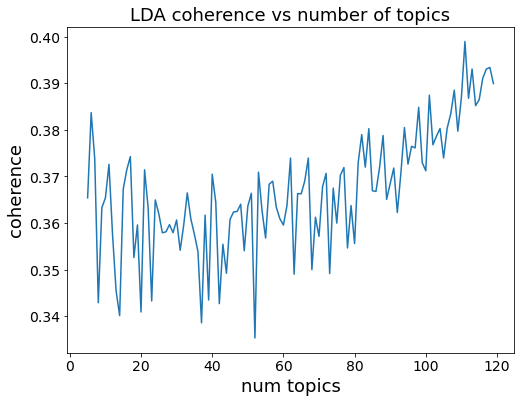

In [47]:
x = range(5, 120)
y = coherence_scores

fig, ax = plt.subplots(figsize=(8,6))
ax.plot(x, y)

plt.xlabel('num topics', fontsize=18)
plt.ylabel('coherence', fontsize=18)
plt.title('LDA coherence vs number of topics', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

In [49]:
plt.savefig('../images/lda_coherence.png')

<Figure size 432x288 with 0 Axes>

In [46]:
list(range(5,120))[np.argmax(coherence_scores)]

111

#### Investigate 'optimal' topic number model

The maximum coherence value in the range searched appears to be 111. However, it seems like coherence will continue to increase with more topics. Additionally, 111 is already quite high. Instead, we'll pick an earlier max of ~17 topics as the 'right' number of topics.

In [50]:
# Set training parameters
num_topics = 17
chunksize = 2000
passes = 20
iterations = 400
eval_every = 5  

# Make a index to word dictionary.
temp = dictionary[0]  # This is only to "load" the dictionary.
id2word = dictionary.id2token

model = gensim.models.LdaModel(
    corpus=corpus,
    id2word=id2word,
    chunksize=chunksize,
    alpha='auto',
    eta='auto',
    iterations=iterations,
    num_topics=num_topics,
    passes=passes,
    eval_every=eval_every
)

In [51]:
top_topics = model.top_topics(corpus) #, num_words=20)

# Average topic coherence is the sum of topic coherences of all topics, divided by the number of topics.
avg_topic_coherence = sum([t[1] for t in top_topics]) / num_topics
print('Average topic coherence: %.4f.' % avg_topic_coherence)

from pprint import pprint
pprint(top_topics)

Average topic coherence: -10.4907.
[([(0.12516052, 'please'),
   (0.08153919, 'help'),
   (0.07908079, 'made'),
   (0.07508949, 'time'),
   (0.058710024, 'showing'),
   (0.056938652, 'please_help'),
   (0.054309707, 'isnt'),
   (0.048946016, 'payment'),
   (0.0322507, 'card'),
   (0.03158759, 'back'),
   (0.030514983, 'pending'),
   (0.028451063, 'app'),
   (0.02764129, 'still'),
   (0.024524467, 'reason'),
   (0.019483872, 'refund'),
   (0.017030083, 'one'),
   (0.015483591, 'yesterday'),
   (0.015170098, 'number'),
   (0.012674015, 'purchase'),
   (0.011751735, 'yet')],
  -7.35162825605177),
 ([(0.21606034, 'payment'),
   (0.114384264, 'card'),
   (0.07750783, 'cancel'),
   (0.055008415, 'made'),
   (0.05233831, 'virtual_card'),
   (0.046231918, 'virtual'),
   (0.03150368, 'cancelled'),
   (0.031130899, 'couple'),
   (0.030511014, 'transaction'),
   (0.029362062, 'account'),
   (0.024931824, 'yet'),
   (0.024910191, 'dont'),
   (0.024256943, 'day'),
   (0.023310054, 'hasnt'),
   (0.0

In [53]:
topics = model.print_topics(num_words=5)
for topic in topics:
    print(topic)

(0, '0.125*"please" + 0.082*"help" + 0.079*"made" + 0.075*"time" + 0.059*"showing"')
(1, '0.152*"would" + 0.126*"like" + 0.108*"need" + 0.087*"would_like" + 0.063*"possible"')
(2, '0.150*"atm" + 0.110*"tried" + 0.091*"amount" + 0.083*"withdraw" + 0.075*"wrong"')
(3, '0.123*"refund" + 0.116*"tell" + 0.094*"going" + 0.066*"statement" + 0.062*"passcode"')
(4, '0.203*"charged" + 0.202*"topup" + 0.157*"fee" + 0.105*"transaction" + 0.063*"charged_fee"')
(5, '0.179*"want" + 0.162*"bank" + 0.083*"transfer" + 0.076*"account" + 0.070*"top"')
(6, '0.375*"card" + 0.078*"disposable" + 0.059*"using" + 0.049*"virtual" + 0.046*"used"')
(7, '0.216*"payment" + 0.114*"card" + 0.078*"cancel" + 0.055*"made" + 0.052*"virtual_card"')
(8, '0.195*"exchange" + 0.168*"rate" + 0.136*"exchange_rate" + 0.130*"currency" + 0.080*"im"')
(9, '0.243*"transfer" + 0.097*"long" + 0.091*"pending" + 0.089*"withdrawal" + 0.086*"cash"')
(10, '0.179*"money" + 0.072*"mastercard" + 0.061*"visa" + 0.060*"transfer" + 0.058*"hasnt"'

In [54]:
# compute coherence score
coherence_model_lda = CoherenceModel(model=model, 
                                     texts=all_tokens, 
                                     dictionary=dictionary, 
                                     coherence='c_v')

coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)

print('\nPerplexity: ', model.log_perplexity(corpus))


Coherence Score:  0.3523791379051739

Perplexity:  -4.930786574073809


### Visualize the topics

pyLDAvis (https://github.com/bmabey/pyLDAvis) is a helpful tool for visualizing topics (although it doesn’t play nicely with Jupyter lab https://github.com/jupyterlab/jupyterlab/issues/7959) 

In [ ]:
pyLDAvis.enable_notebook()
LDAvis_prepared = pyLDAvis.gensim_models.prepare(model, corpus, dictionary)
LDAvis_prepared

In [ ]:
pyLDAvis.disable_notebook()

## Hierarchical Dirichlet Process

In [55]:
hdp = gensim.models.HdpModel(corpus, dictionary)

In [56]:
topic_info = hdp.print_topics(num_topics=-1, num_words=10)
len(topic_info)

0

In [57]:
len(hdp.get_topics())

150

In theory, the HDP algorithm is supposed to be able to automatically determine the number of topics in the data, but this dataset might be too small for it to be useful. See https://radimrehurek.com/gensim/models/hdpmodel.html for more details.

## CorEx

In [58]:
tfidf_vectorizer = TfidfVectorizer(max_df = 1.0, 
                                   min_df = 5, 
                                   ngram_range = (1, 2)
                                  )

vectorizer = tfidf_vectorizer.fit(X)
tfidf = vectorizer.transform(X)
vocab = vectorizer.get_feature_names()
print(len(vocab))

309


### Without anchor words

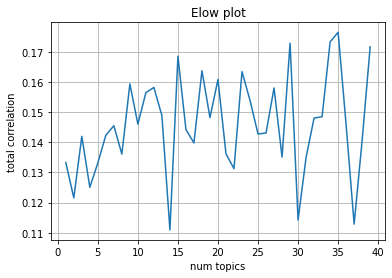

In [59]:
total_correlation = []

for n in range(1, 40):
    anchors = []
    model = ct.Corex(n_hidden = n, seed = 23)
    model = model.fit(tfidf, words=vocab)
    total_correlation.append(model.tc)
    
x = range(1, 40)
y = total_correlation

fig, ax = plt.subplots()
ax.plot(x, y)

ax.set(xlabel = 'num topics', ylabel = 'total correlation', title = 'Elow plot')
ax.grid()

plt.show()

In [60]:
anchors = []
model = ct.Corex(n_hidden=9, seed = 23)
model = model.fit(tfidf, words=vocab)

In [61]:
for i, topic_ngrams in enumerate(model.get_topics(n_words=10)):
    topic_ngrams = [ngram[0] for ngram in topic_ngrams if ngram[1] > 0]
    print(f"Topic #{i+1}: {', '.join(topic_ngrams)}")

Topic #1: verify, verification, identity, topup, top, verify topup, auto, source, payment, credit card
Topic #2: virtual, virtual card, disposable, disposable card, disposable virtual, activate, activate card, card, new card, wont
Topic #3: rate, exchange rate, exchange, wrong, correct, foreign, getting cash, item, cash, currency
Topic #4: direct debit, direct, debit, recognize, dont recognize, dont, set, strange, payment app, see
Topic #5: mastercard, visa, visa mastercard, pin, change pin, change, physical, physical card, card pin, give
Topic #6: would like, like, would, delete account, delete, like know, service, know, purchase, understand
Topic #7: european, european bank, bank, get charged
Topic #8: extra, extra fee, charged extra
Topic #9: left, hotel, phone


In [62]:
anchor_df = data_sample.copy()

topic_df = pd.DataFrame(model.transform(tfidf), 
                        columns=[f"topic_{i+1}" for i in range(model.n_hidden)]
                       ).astype(float)

topic_df.index = anchor_df.index
anchor_df = pd.concat([anchor_df, topic_df], axis=1)
anchor_df.sample(5)

,Unnamed: 0,text,category,cleaned_text,topic,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9
515,4583,I need an ATM right now!,atm_support,need atm right,12,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
911,9356,Why was I charged for cash withdrawal?,cash_withdrawal_charge,charged cash withdrawal,6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
467,6961,I would like to change the the PIN on my card.,change_pin,would like change pin card,10,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
602,9268,How do I active this card?,activate_my_card,active card,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
975,685,"In my statement, there was an extra €1 fee",extra_charge_on_statement,statement extra fee,9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [65]:
anchor_df[anchor_df['topic_4']==1].sample(5)

,Unnamed: 0,text,category,cleaned_text,topic,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9
612,4646,I see a direct debit transaction in my history that I did not set up.,direct_debit_payment_not_recognised,see direct debit transaction history set,4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
188,3528,There's a payment in the app I don't recognize.,card_payment_not_recognised,there payment app dont recognize,3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
424,4797,I do not recognize a direct debit payment that I see on my app,direct_debit_payment_not_recognised,recognize direct debit payment see app,4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
923,3553,There is a payment I don't recognize,card_payment_not_recognised,payment dont recognize,3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
50,4696,I see a direct debit that isn't mine? How can I get my money back?,direct_debit_payment_not_recognised,see direct debit isnt mine get money back,4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


### With anchor words

In [66]:
anchors = [
    ['card'], 
    ['money'], 
    ['account'], 
    ['payment'], 
    ['transfer'], 
    ['cash'], 
    ['exchange', 'rate'], 
    ['charged'], 
    ['withdrawal'], 
    ['fee'], 
    ['atm'], 
    ['refund'], 
    ['pending'], 
    ['currency'], 
    ['transaction'], 
    ['declined'], 
    ['pin'], 
    ['balance'], 
    ['identity'], 
    ['stolen'], 
    ['foreign']]

anchors = [
    [a for a in topic if a in vocab]
    for topic in anchors
]

model = ct.Corex(n_hidden=len(anchors), seed=42)
model = model.fit(tfidf, words=vocab, anchors=anchors, anchor_strength=5)
print(f"model total correlation: {model.tc}")

model total correlation: 3.5072613908472703


In [67]:
for i, topic_ngrams in enumerate(model.get_topics(n_words=10)):
    topic_ngrams = [ngram[0] for ngram in topic_ngrams if ngram[1] > 0]
    print(f"Topic #{i+1}: {', '.join(topic_ngrams)}")

Topic #1: card, virtual card, virtual, disposable, new card, disposable card, get card, disposable virtual, activate, using card
Topic #2: money, money account, transferred, get money, transferred money, withdraw money, add money, money back, add, friend
Topic #3: account, top account, delete, delete account, daughter, card account, wrong account, topup, dont see, please
Topic #4: payment, card payment, payment card, payment cancelled, payment app, payment made, recognize, cancelled, made payment, dont recognize
Topic #5: transfer, bank transfer, swift, money transfer, bank, transfer money, long, take, china, long take
Topic #6: cash, getting cash, cash deposit, withdrew, deposited, deposit, withdraw, need, got, would
Topic #7: exchange, rate, exchange rate, wrong, correct, item, eur, abroad, top, think
Topic #8: charged, charged extra, get charged, twice, may, reason, know
Topic #9: withdrawal, cash withdrawal, strange, please help, wasnt, believe
Topic #10: fee, charged fee, extra fe